# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

2024-03-07 09:13:04.400754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 09:13:04.400868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 09:13:04.545625: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Setup Embeddings

In [5]:
from gensim.models import KeyedVectors

# Load the model from the .model file
embeddings = KeyedVectors.load("/kaggle/input/embeddings/text8_word2vec.model")
vocab_size = len(embeddings.wv)
word_embeddings = tf.zeros((vocab_size, 100)).numpy()

# Fill the tensor by accessing word vectors
for i, word in enumerate(embeddings.wv.index_to_key):
    embedding = embeddings.wv[word]
    word_embeddings[i] = embedding

word_embeddings = tf.convert_to_tensor(word_embeddings)
dictionary = list(embeddings.wv.key_to_index.keys())


In [4]:
embeddings = tf.convert_to_tensor(np.load("/kaggle/input/embeddings-1m/embeddings-1M.npy"))

In [5]:
vocab_size = len(embeddings)

In [6]:
vocab_size, embeddings.shape

(32000, TensorShape([32000, 100]))

In [7]:
embeddings.wv.most_similar("belgium")

[('netherlands', 0.8115893602371216),
 ('france', 0.7129966020584106),
 ('luxembourg', 0.690894365310669),
 ('wallonia', 0.675728440284729),
 ('flanders', 0.6561781764030457),
 ('switzerland', 0.6527379751205444),
 ('germany', 0.635360598564148),
 ('alsace', 0.6298046708106995),
 ('vlaanderen', 0.6127011775970459),
 ('limburg', 0.5989093780517578)]

# Next Word Models

In [10]:
def next_word_avg(sentence, embeddings, topn=10) :
  tokens = word_tokenize(sentence.lower())
  sequence = np.array([embeddings.wv[word] for word in tokens])
  print(sequence.shape)
  avg = np.sum(sequence, axis=0) / sequence.shape[0]
  output = embeddings.wv.most_similar(positive=[avg], topn=topn)
  return output

In [8]:
def next_word_basic(sentence, embeddings, topn=10) :
    tokens = word_tokenize(sentence.lower())
    stop_words = stopwords.words('english')
    words = [token for token in tokens if token not in stop_words]

    context = np.array([embeddings.wv[word] for word in words[:-1]]) # (T, d)
    query = np.array([embeddings.wv[words[-1]]]) # (d)

    query = tf.squeeze(query, axis=0) #  (d, 1)

    output = context * query # (T, d)

    output = tf.reduce_sum(output, axis=1, keepdims=True) # (T, 1)

    soft = tf.transpose(tf.nn.softmax(tf.transpose(output))) # (T, 1)

    soft = tf.tile(soft, [1, tf.shape(context)[1]]) # (T, d)

    last = soft * context # (T, d)

    last = tf.reduce_sum(last, axis=0) # (d,)

    # last = last.numpy()

    output = embeddings.wv.most_similar(positive=[last.numpy()], topn=topn)

    return output

In [7]:
class Attention(keras.Model):
  def __init__(self, embedding_dim):
    super().__init__()
    self.qkv_layer = keras.layers.Dense(embedding_dim*3)
    self.dim = embedding_dim

  def call(self, context, mask=None, scaled=True):
    qkv = self.qkv_layer(context)
    # print(qkv.shape)
    q, k, v = tf.split(qkv, num_or_size_splits=3, axis=-1)

    attention_scores = tf.matmul(q, tf.transpose(k, perm=[0, 2, 1]))

    if scaled:
      attention_scores = tf.divide(attention_scores, np.sqrt(attention_scores.shape[-1]))

    if mask is not None:
      attention_scores = tf.where(mask == 0, -np.inf, attention_scores)

    causal_mask = tf.linalg.band_part(tf.ones([context.shape[-2], context.shape[-2]]), -1, 0)
    causal_mask = tf.expand_dims(causal_mask, axis=0)
    causal_mask = tf.tile(causal_mask, [tf.shape(context)[0], 1, 1])
    attention_scores = tf.where(causal_mask == 0, -np.inf, attention_scores)
    attention_scores = tf.nn.softmax(attention_scores, axis=-1)
    attention_scores = tf.matmul(attention_scores, v) # T, d
    return attention_scores


In [58]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, embed_dim, max_len=5):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len

    def call(self, inputs):
        pos_encoding = self.positional_encoding(self.max_len, self.embed_dim)
        return inputs + pos_encoding[: inputs.shape[1], :]

    def positional_encoding(self, max_len, embed_dim):
        pos_enc = np.array([
            [pos / np.power(10000, 2 * (j // 2) / embed_dim) for j in range(embed_dim)]
            for pos in range(max_len)
        ])
        pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])
        pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])
        return tf.constant(pos_enc, dtype=tf.float32)


In [59]:
class NextWordWithPos(keras.Model):
    def __init__(self, vocab_size, embed_dim, embeddings):
        super().__init__()
        self.attention = Attention(embed_dim)
        self.dim = embed_dim
        self.pos_encoding = PositionalEncoding(embed_dim)
        self.dense = keras.layers.Dense(vocab_size, activation='softmax')

    def call(self, sequence):
        sequence_embeddings = self.pos_encoding(sequence)
        context_vector = self.attention(sequence_embeddings)
        context_vector = tf.reduce_mean(context_vector, axis=1)
        next_word_predictions = self.dense(context_vector)

        return next_word_predictions


In [25]:
class NextWord(keras.Model):
  def __init__(self, vocab_size, embed_dim, embeddings):
    super().__init__()
    self.attention = Attention(embed_dim)
    self.dim = embed_dim
    self.embeddings = embeddings
    self.dense = keras.layers.Dense(vocab_size, activation='softmax')

  def call(self, sequence):
    # att_embed = tf.matmul(self.attention(sequence), tf.transpose(self.embeddings))
    # att_embed = tf.convert_to_tensor(att_embed)
    context_vector = self.attention(sequence)
    context_vector = tf.reduce_mean(context_vector, axis=1)
    next_word_predictions = self.dense(context_vector)
    return next_word_predictions


In [10]:
def next_word(sent, embeddings, model, k = 1):
    tokens = word_tokenize(sent.lower())
    # stop_words = stopwords.words('english')
    # words = [token for token in tokens if token not in stop_words]
    context = tf.constant([embeddings.wv[word] for word in tokens])
    context = tf.expand_dims(context, axis=0)
    logits = model(context)
    print(logits.shape)
    # lm_head = tf.nn.softmax(logits, axis = -1)
    # TODO: Random sampling for word selection
    results = tf.math.top_k(logits, k).indices.numpy()
    # return results
    return [embeddings.wv.index_to_key[result] for result in results[-1]]


# Test Models

In [ ]:
next_word_avg("The oldest city in the world is", embeddings)

In [ ]:
next_word_basic("The oldest city in the world is", embeddings=embeddings, topn=5)


[('oldest', 0.998138964176178),
 ('earliest', 0.6709460020065308),
 ('largest', 0.612809956073761),
 ('today', 0.5407142639160156),
 ('richest', 0.5309126377105713)]

In [11]:
model = NextWord(71290, 100, word_embeddings)

In [12]:
result = next_word("The capital of the united states of america is",
          embeddings,
          model, k = 5)
result

(1, 71290)


['rttemberg', 'csma', 'pickup', 'machel', 'shorebirds']

# Create the dataset

In [9]:
# Turkish Dataset
import pandas as pd

df = pd.read_csv("/kaggle/input/corpus/texts.csv")

In [35]:
concatenated_text = ' '.join([text for text in df['text'][1000:2000] if isinstance(text, str)])
tokens = tokenizer.encode(concatenated_text)
len(tokens)

1028954

In [36]:
import collections

def remove_low_frequency_tokens(tokens, min_freq=5):
    # Count the frequency of each token
    token_freq = collections.Counter(tokens)

    # Filter out tokens with frequency less than min_freq
    filtered_tokens = [token for token in tokens if token_freq[token] >= min_freq]

    return filtered_tokens
tokens = remove_low_frequency_tokens(tokens, min_freq=5)
len(tokens)

1017513

In [37]:
sequences = []
labels = []
sequence_size = 5
for i in range(len(tokens) - sequence_size):

    sequence = [embeddings[word] for word in tokens[i : i + sequence_size]]
    label = tokens[i + sequence_size]
    sequences.append(sequence)
    labels.append(label)
    if (i%50000 == 0):
        print(f'{i} / {len(tokens) - sequence_size}: Complete')

len(sequences), len(sequences[0]), len(labels)

0 / 1017508: Complete
50000 / 1017508: Complete
100000 / 1017508: Complete
150000 / 1017508: Complete
200000 / 1017508: Complete
250000 / 1017508: Complete
300000 / 1017508: Complete
350000 / 1017508: Complete
400000 / 1017508: Complete
450000 / 1017508: Complete
500000 / 1017508: Complete
550000 / 1017508: Complete
600000 / 1017508: Complete
650000 / 1017508: Complete
700000 / 1017508: Complete
750000 / 1017508: Complete
800000 / 1017508: Complete
850000 / 1017508: Complete
900000 / 1017508: Complete
950000 / 1017508: Complete
1000000 / 1017508: Complete


(1017508, 5, 1017508)

# Old Data

In [11]:
# Import the data
raw_text = open('/kaggle/input/text8-wiki/text8.txt', 'r').read()

# Convert to tokens and remove
tokens =  list(raw_text.split())[:5000000]
tokens = [embeddings.wv.key_to_index[word] for word in tokens if word in dictionary]

In [12]:
sequences = []
labels = []
sequence_size = 5
for i in range(len(tokens) - sequence_size):
  sequence = [embeddings.wv[word] for word in tokens[i : i + sequence_size]]
  label = tokens[i + sequence_size]
  sequences.append(sequence)
  labels.append(label)

In [38]:
sequences = np.array(sequences)
labels = np.array(labels)
print(sequences.shape, labels.shape)

# split the dataset into training and validation sets
train_size = int(0.97 * len(sequences))
train_sequences, val_sequences = sequences[:train_size], sequences[train_size:]
train_labels, val_labels = labels[:train_size], labels[train_size:]
print(train_sequences.shape, val_sequences.shape, train_labels.shape, val_labels.shape)


# Create a tf.data.Dataset for the training set
train_dataset = tf.data.Dataset.from_tensor_slices((train_sequences, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

# Create a tf.data.Dataset for the validation set
val_dataset = tf.data.Dataset.from_tensor_slices((val_sequences, val_labels))
val_dataset = val_dataset.batch(64).prefetch(tf.data.AUTOTUNE)

(1017508, 5, 100) (1017508,)
(986982, 5, 100) (30526, 5, 100) (986982,) (30526,)


In [39]:
def one_hot_encode(labels, vocab_size):
    return tf.one_hot(labels, depth=vocab_size, dtype=tf.float32)

In [40]:
train_dataset = train_dataset.map(lambda seq, label: (seq, one_hot_encode(label, vocab_size)))
val_dataset = val_dataset.map(lambda seq, label: (seq, one_hot_encode(label, vocab_size)))

In [ ]:
train_dataset.save("/kaggle/working/")
val_dataset.save("/kaggle/working/")

In [26]:
def generate_sequences_nw(raw_text):
  # Convert to tokens and remove
  tokens =  list(raw_text.split())[:2000000]
  tokens = [word for word in tokens if word in dictionary]


# old

In [39]:
dataset = []
labels = []
i = 0
for line in data:
  sequences = np.array_split(line, 625)
  for seq in sequences:
    tok = []
    # lab = [0 for i in range(vocab_size)]
    # lab = []
    for word in seq:
      try:
        tok.append(embeddings.wv[word])
        # lab.append(embeddings.wv.key_to_index[word])
      except:
        tok = []
        break
    # print(tok)
    if len(tok) != 0:
      # print(embeddings.wv.key_to_index[seq[-1]])
      lab = embeddings.wv.key_to_index[seq[-1]]
      dataset.append(tok[:-1])
      labels.append(lab) # make indices
  i += 1
  if i == 5: break

print(len(dataset))
print(len(labels))


2675

2675


# Train the model

In [41]:
model = NextWord(32000, 100, embeddings)

In [42]:
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.CategoricalAccuracy()
top1 = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top5 = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
top10 = tf.keras.metrics.TopKCategoricalAccuracy(k=10)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metric, top1, top5, top10])

In [43]:
history = model.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
)

Epoch 1/3
15422/15422 ━━━━━━━━━━━━━━━━━━━━ 99s 6ms/step - categorical_accuracy: 0.0552 - loss: 7.3443 - top_k_categorical_accuracy: 0.0552 - top_k_categorical_accuracy_1: 0.1413 - top_k_categorical_accuracy_2: 0.1840 - val_categorical_accuracy: 0.0688 - val_loss: 6.6838 - val_top_k_categorical_accuracy: 0.0688 - val_top_k_categorical_accuracy_1: 0.1949 - val_top_k_categorical_accuracy_2: 0.2564
Epoch 2/3
15422/15422 ━━━━━━━━━━━━━━━━━━━━ 93s 6ms/step - categorical_accuracy: 0.0718 - loss: 6.7288 - top_k_categorical_accuracy: 0.0718 - top_k_categorical_accuracy_1: 0.1755 - top_k_categorical_accuracy_2: 0.2341 - val_categorical_accuracy: 0.0765 - val_loss: 6.5742 - val_top_k_categorical_accuracy: 0.0765 - val_top_k_categorical_accuracy_1: 0.2198 - val_top_k_categorical_accuracy_2: 0.2784
Epoch 3/3
15422/15422 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - categorical_accuracy: 0.0788 - loss: 6.5625 - top_k_categorical_accuracy: 0.0788 - top_k_categorical_accuracy_1: 0.1867 - top_k_categorical_accura

In [44]:
model.summary()

Model: "next_word_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ attention_2 (Attention)         │ ?                      │        30,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │     3,232,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,786,902 (37.33 MB)

 Trainable params: 3,262,300 (12.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,524,602 (24.89 MB)

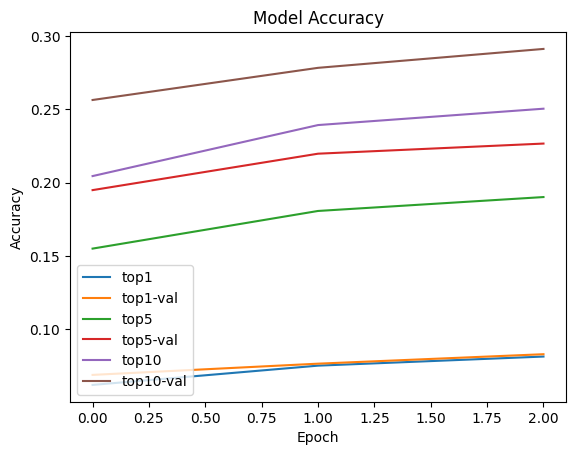

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['top_k_categorical_accuracy'], label='top1')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='top1-val')
plt.plot(history.history['top_k_categorical_accuracy_1'], label='top5')
plt.plot(history.history['val_top_k_categorical_accuracy_1'], label='top5-val')
plt.plot(history.history['top_k_categorical_accuracy_2'], label='top10')
plt.plot(history.history['val_top_k_categorical_accuracy_2'], label='top10-val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc="lower left")
plt.show()

In [60]:
modelwp = NextWordWithPos(32000, 100, embeddings)

In [61]:
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.CategoricalAccuracy()
top1 = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top5 = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
top10 = tf.keras.metrics.TopKCategoricalAccuracy(k=10)
modelwp.compile(optimizer=optimizer, loss=loss_fn, metrics=[metric, top1, top5, top10])

In [62]:
historywp = modelwp.fit(
    train_dataset,
    epochs=3,
    validation_data=val_dataset,
)

Epoch 1/3
15422/15422 ━━━━━━━━━━━━━━━━━━━━ 104s 7ms/step - categorical_accuracy: 0.0534 - loss: 7.3487 - top_k_categorical_accuracy: 0.0534 - top_k_categorical_accuracy_1: 0.1378 - top_k_categorical_accuracy_2: 0.1788 - val_categorical_accuracy: 0.0728 - val_loss: 6.8790 - val_top_k_categorical_accuracy: 0.0728 - val_top_k_categorical_accuracy_1: 0.1775 - val_top_k_categorical_accuracy_2: 0.2386
Epoch 2/3
15422/15422 ━━━━━━━━━━━━━━━━━━━━ 97s 6ms/step - categorical_accuracy: 0.0699 - loss: 6.7442 - top_k_categorical_accuracy: 0.0699 - top_k_categorical_accuracy_1: 0.1691 - top_k_categorical_accuracy_2: 0.2243 - val_categorical_accuracy: 0.0836 - val_loss: 6.7477 - val_top_k_categorical_accuracy: 0.0836 - val_top_k_categorical_accuracy_1: 0.1906 - val_top_k_categorical_accuracy_2: 0.2517
Epoch 3/3
15422/15422 ━━━━━━━━━━━━━━━━━━━━ 98s 6ms/step - categorical_accuracy: 0.0760 - loss: 6.5758 - top_k_categorical_accuracy: 0.0760 - top_k_categorical_accuracy_1: 0.1793 - top_k_categorical_accur

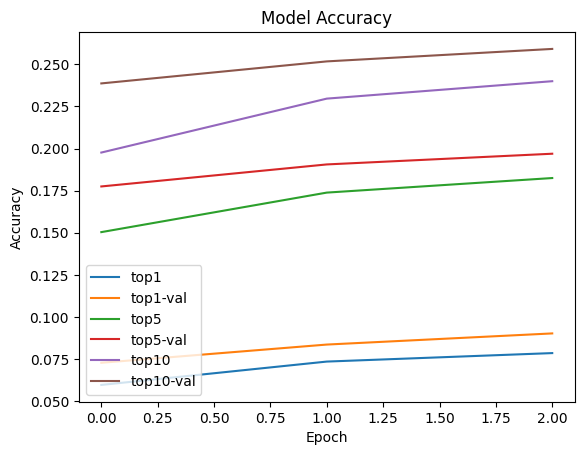

In [63]:
plt.plot(historywp.history['top_k_categorical_accuracy'], label='top1')
plt.plot(historywp.history['val_top_k_categorical_accuracy'], label='top1-val')
plt.plot(historywp.history['top_k_categorical_accuracy_1'], label='top5')
plt.plot(historywp.history['val_top_k_categorical_accuracy_1'], label='top5-val')
plt.plot(historywp.history['top_k_categorical_accuracy_2'], label='top10')
plt.plot(historywp.history['val_top_k_categorical_accuracy_2'], label='top10-val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc="lower left")
plt.show()

In [30]:
result = next_word("the eiffel tower is located in the",
          embeddings,
          model, k = 15)
result

(1, 71290)


['the',
 'of',
 'in',
 'a',
 'one',
 'and',
 'by',
 'from',
 'to',
 's',
 'with',
 'on',
 'first',
 'nine',
 'two']

In [64]:
model.save("next-word-1m-tr.keras")
modelwp.save("next-word-1m-tr-pe.keras")

# MLM

In [ ]:
class MLM(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(MLM, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.dense1 = tf.keras.layers.Dense(64, activation="relu")
    self.dense2 = tf.keras.layers.Dense(vocab_size, activation="softmax")

  def call(self, inputs):
    word_ids = inputs
    embeddings = self.embedding(word_ids)
    encoded = self.dense1(embeddings)
    outputs = self.dense2(encoded)
    return outputs


# Create model and optimizer
model = MLM()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Train the model
for epoch in range(10):
  with tf.GradientTape() as tape:
    predictions = model(word_ids)
    loss = tf.keras.losses.sparse_categorical_crossentropy(word_ids, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

# Make predictions
predicted_id = tf.argmax(predictions[masked_index]).numpy()
predicted_word = word2vec_model.key_to_token[predicted_id]
print("Predicted word:", predicted_word)



In [ ]:
sentence = "The cat sat on the _."
masked_index = 4  # Index of the word to be masked
word_ids = [word2vec_model.key_to_index[word] for word in sentence.split()]
word_ids[masked_index] = word2vec_model.key_to_index["<MASK>"]  # Replace masked word with special token
